<a href="https://colab.research.google.com/github/seoyujiin/esaa_ob/blob/main/%EC%BA%90%EA%B8%80_%ED%95%84%EC%82%AC_%EC%BC%80%EB%9D%BC%EC%8A%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**기본 분류: 의류 이미지 분류**

https://www.tensorflow.org/tutorials/keras/classification?hl=ko

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.14.0


## 패션 MNIST 데이터셋 임포트하기

* 10개의 범주(category)와 70000개의 흑백 이미지로 구성된 패션 MNIST 데이터셋 사용
* 이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 옷 품목을 나타냄
* MNIST 데이터셋은 손글씨 숫자(0, 1, 2 등)의 이미지로 이루어져 있음, 여기서 사용하려는 옷 이미지와 동일한 포맷
* 60000개의 이미지를 사용하여 네트워크를 훈련하고 10000개의 이미지를 사용하여 네트워크에서 이미지 분류를 학습한 정도를 평가

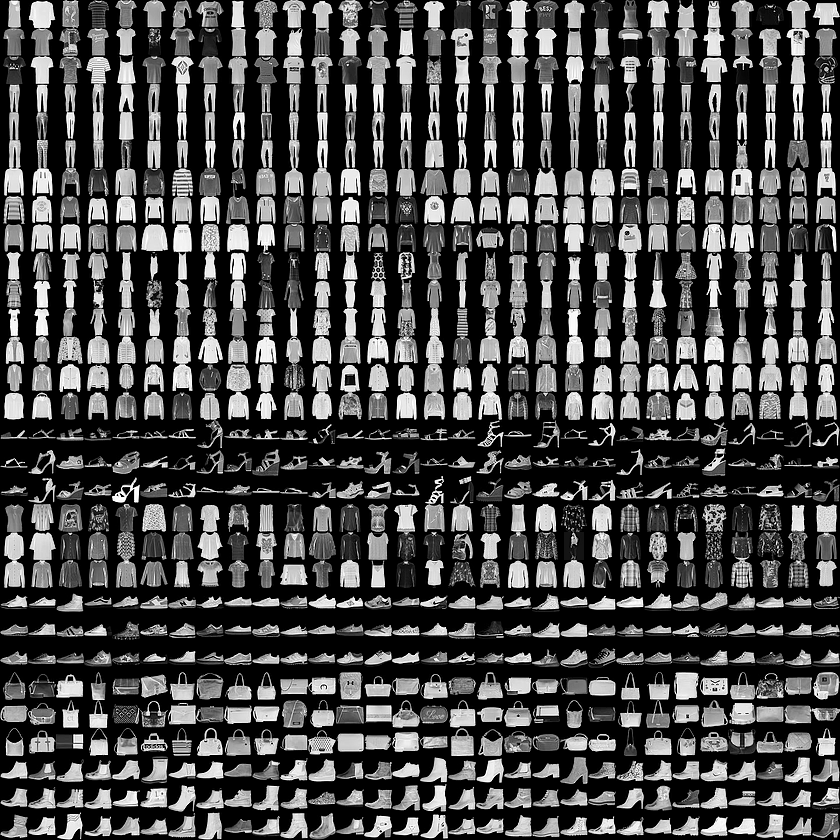

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


* load_data() 함수 호출하면 네 개의 넘파이 배열이 반환됨:
  * `train_images`와 `train_labels` 배열은 모델 학습에 사용되는 훈련 세트
  * `test_images`와 `test_labels` 배열은 모델 테스트에 사용되는 테스트 세트
* 이미지는 28x28 크기의 넘파이 배열이고 픽셀 값은 0과 255 사이
* 레이블(label)은 0에서 9까지의 정수 배열이며 이 값은 이미지에 있는 옷의 클래스(class)를 나타냄:
  * 0: T-shirt/top
  * 1: Trouser
  * 2: Pullover
  * 3: Dress
  * 4: Coat
  * 5: Sandal
  * 6: Shirt
  * 7: Sneaker
  * 8: Bag
  * 9: Ankle boot

In [3]:
# 데이터셋에 클래스 이름이 들어있지 않으므로 나중에 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 데이터 탐색

* 훈련 세트에 60000개의 이미지가 있음, 각 이미지는 28x28 픽셀로 표현

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
len(train_labels)

60000

* 각 레이블은 0과 9 사이의 정수

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

* 테스트 세트에는 10000개의 이미지, 28x28 픽셀로 표현

In [7]:
test_images.shape

(10000, 28, 28)

In [8]:
len(test_labels)

10000

## 데이터 전처리

* 네트워크를 훈련하기 전에 데이터를 전처리해야 함
* 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이

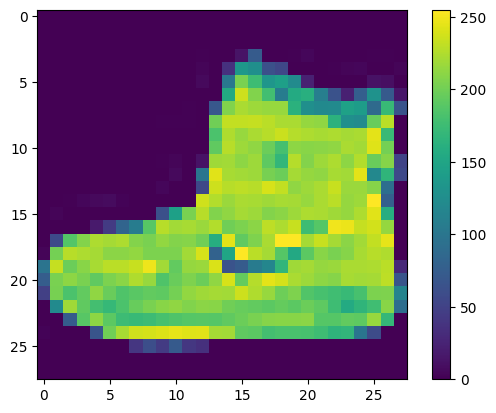

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

* 신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

* 훈련 세트에서 처음 25개 이미지와 그 아래 클래스 이름 출력
* 데이터 포맷이 올바른지 확인하고 네트워크 구성과 훈련할 준비를 마침

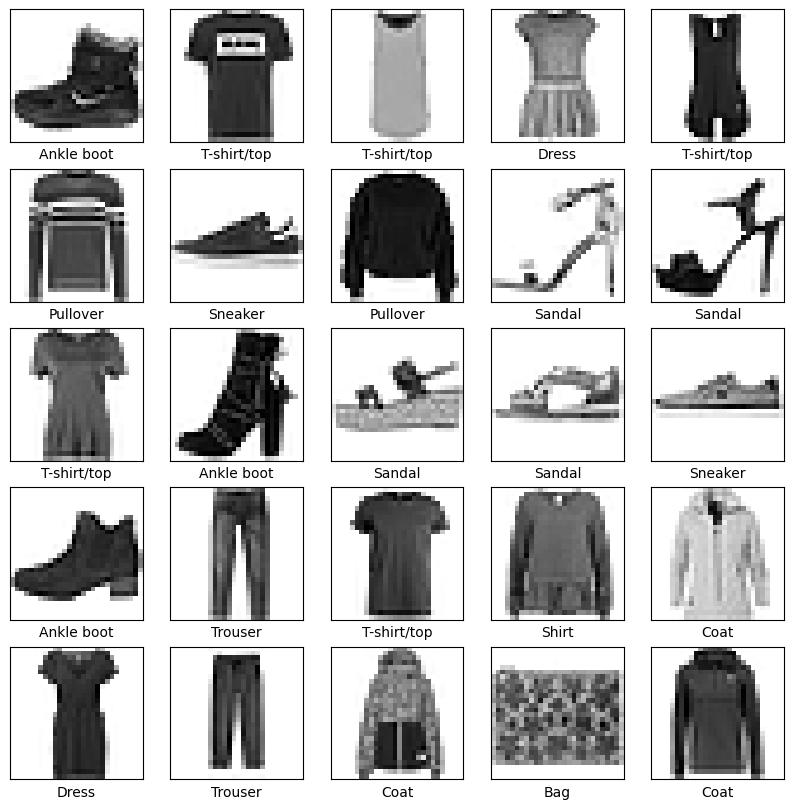

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 모델 구성

### 층 설정

* 신경망의 기본 빌딩 블록은 레이어
* `tf.keras.layers.Dense`와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습
* `tf.keras.layers.Flatten`은 2차원 배열(28 x 28 픽셀)의 이미지 포맷을 28 * 28 = 784 픽셀의 1차원 배열로 변환
* 픽셀을 펼친 후에는 두 개의 `tf.keras.layers.Dense` 층이 연속되어 연결됨. 이 층을 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부름
  * 첫 번째 `Dense` 층은 128개의 노드(또는 뉴런)를 가짐. 두 번째 (마지막) 층은 10개의 노드의 소프트맥스(softmax) 층. 이 층은 10개의 확률을 반환하고 반환된 값의 전체 합은 1. 각 노드는 현재 이미지가 10개 클래스 중 하나에 속할 확률을 출력

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

### 모델 컴파일

* 손실 함수 - 훈련 중 모델이 얼마나 정확한지 측정. 모델을 올바른 방향으로 "조정"하려면 이 함수를 최소화해야 함
* 옵티마이저 - 모델이 인식하는 데이터와 해당 손실 함수를 기반으로 모델이 업데이트되는 방식
* 메트릭 - 훈련 및 테스트 단계를 모니터링하는 데 사용됨. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 모델 훈련

1. 훈련 데이터를 모델에 주입합니다-이 예에서는 `train_images`와 `train_labels` 배열입니다.
2. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.
3. 테스트 세트에 대한 모델의 예측을 만듭니다-이 예에서는 `test_images` 배열입니다. 이 예측이 `test_labels` 배열의 레이블과 맞는지 확인합니다.
4. 예측이 `test_labels` 배열의 레이블과 일치하는지 확인합니다.

### 모델 피드
* 훈련 시작하려면 `model.fit` 메서드 호출
* 모델이 훈련되면서 손실과 정확도 지표가 출력됨
* 이 모델은 훈련 세트에서 약 0.88(88%)정도의 정확도를 달성함

In [14]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 21s 10ms/step - loss: 0.5033 - accuracy: 0.8240
Epoch 2/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3752 - accuracy: 0.8637
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3356 - accuracy: 0.8769
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3132 - accuracy: 0.8847
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2957 - accuracy: 0.8907
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2806 - accuracy: 0.8966
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2677 - accuracy: 0.9002
Epoch 8/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2574 - accuracy: 0.9046
Epoch 9/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.2490 - accuracy: 0.9068
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - los

### 정확도 평가
* 테스트 세트의 정확도가 훈련 세트의 정확도보다 조금 낮음
* 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 과대적합(overfitting) 때문
* 과대적합: 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상

In [15]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3340 - accuracy: 0.8814 - 741ms/epoch - 2ms/step

Test accuracy: 0.8813999891281128


### 예측하기
* 훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행할 수 있음
* 소프트맥스 레이어를 연결하여 로짓을 해석하기 쉬운 확률로 변환함

In [16]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [17]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [18]:
# 여기서는 테트 세트에 있는 각 이미지의 레이블을 예측함
# 첫 번째 예측 확인
predictions[0]

array([4.2387074e-07, 1.1613128e-09, 4.8402551e-08, 1.7588510e-09,
       1.1878576e-07, 6.8536814e-04, 1.3800958e-07, 2.5567979e-02,
       3.1264349e-07, 9.7374564e-01], dtype=float32)

* 이 예측은 10개의 숫자 배열로 나타남
* 이 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냄

In [19]:
# 가장 높은 신뢰도를 가진 레이블
np.argmax(predictions[0])

9

* 모델은 이 이미지가 앵클 부츠(class_name[9])라고 가장 확신하고 있음

In [20]:
# 이 값이 맞는지 테스트 레이블 확인
test_labels[0]

9

* 10개 클래스에 대한 예측을 모두 그래프로 표현

In [21]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### 예측 확인
* 훈련된 모델을 사용하여 일부 이미지에 대한 예측 수행 가능
* 0번째 원소의 이미지, 예측, 신뢰도 점수 배열 확인

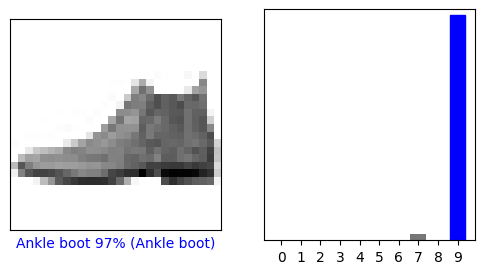

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

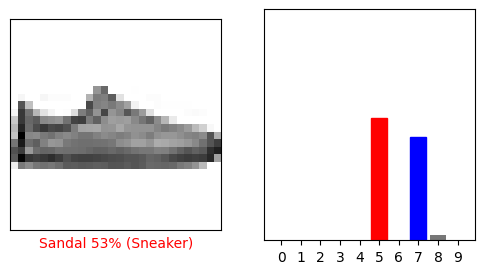

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

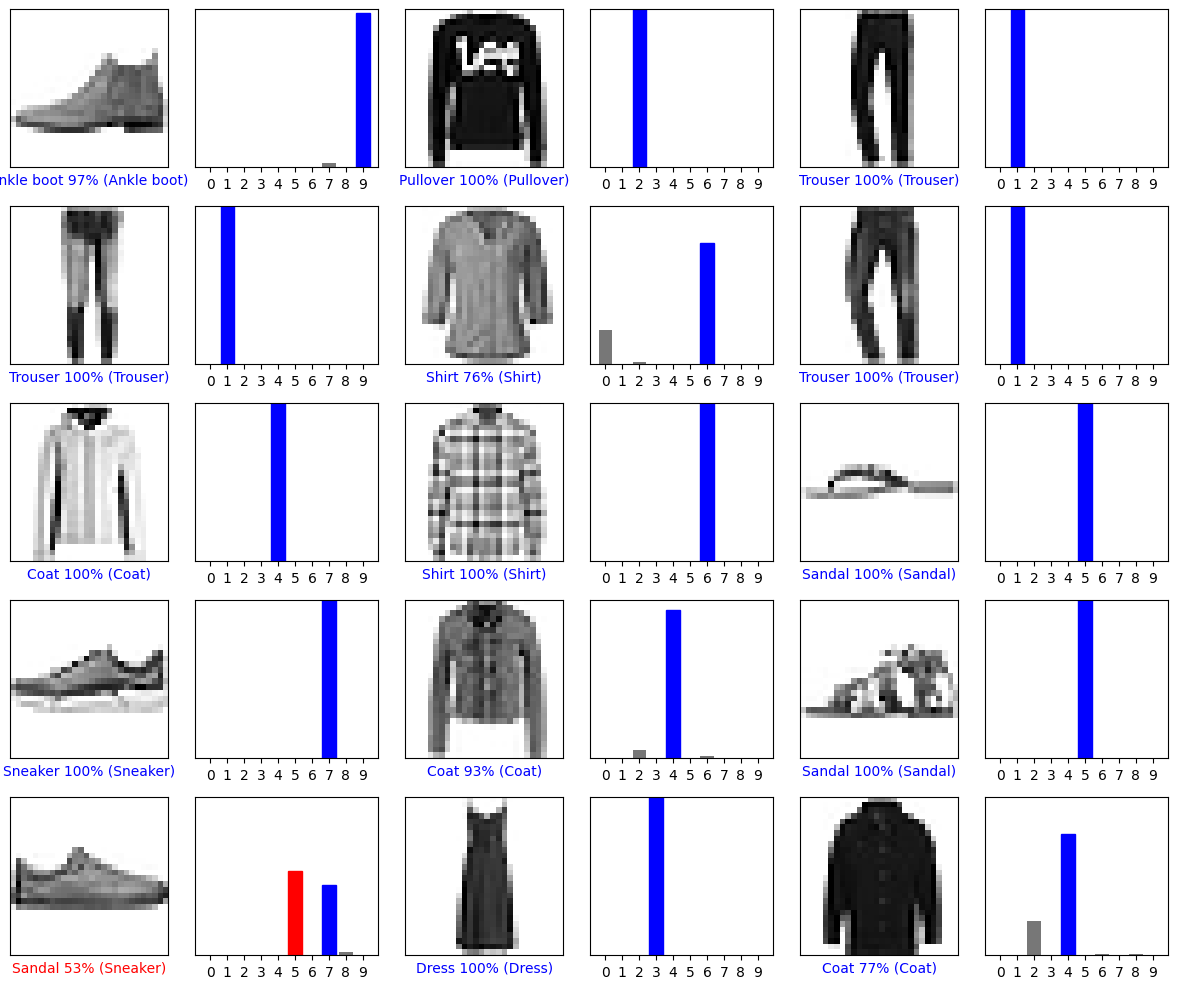

In [24]:
# 몇 개의 이미지의 예측 출력
# 올바르게 예측된 레이블은 파란색, 잘못 예측된 레이블은 빨강
# 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점), 신뢰도 점수가 높을 때도 잘못 예측할 수 있음

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## 훈련된 모델 사용하기
* 훈련된 모델을 사용하여 한 이미지에 대한 예측을 만듦

In [25]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


* `tf.keras` 모델은 한 번의 샘플의 묶음 또는 배치(batch)로 예측을 만드는데 최적화되어 있음
* 하나의 이미지를 사용할 때에도 2차원 배열로 만들어야 함

In [26]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [27]:
# 이미지의 예측 만들기
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 22ms/step
[[3.6172285e-05 1.0383842e-11 9.9881184e-01 1.3952079e-15 1.0408373e-03
  1.1761723e-11 1.1124998e-04 1.6195364e-17 8.7322638e-10 3.3637118e-14]]


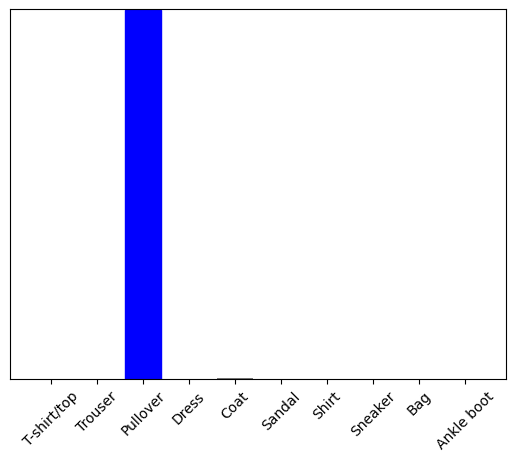

In [28]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

In [29]:
np.argmax(predictions_single[0])

2